## Converting hdf5 to lmdb

References:

* https://symas.com/lightning-memory-mapped-database/
* http://deepdish.io/2015/04/28/creating-lmdb-in-python/
* https://gist.github.com/bearpaw/3a07f0e8904ed42f376e
* http://stackoverflow.com/questions/37337523/how-do-you-load-an-lmdb-file-into-tensorflow
* http://research.beenfrog.com/code/2015/12/30/write-read-lmdb-example.html
* https://lmdb.readthedocs.io/en/release/
* http://stackoverflow.com/questions/8855574/convert-ndarray-from-float64-to-integer
* https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.frombuffer.html
* https://docs.scipy.org/doc/numpy/user/basics.types.html

Reasons:
* LMDB uses memory-mapped files, giving much better I/O performance.
* Works with large datasets. The HDF5 files are always read entirely into memory, so you can’t have any HDF5 file exceed your memory capacity.

Install: pip install lmdb


In [1]:
import lmdb
import h5py
import numpy as np
import matplotlib.pyplot as plt
from driving_data import HandleData
import sys

LMDB_PATH='TestData'
#LMDB_PATH='DrivingData_Complete'
HDF5_PATH='TestData.h5'
#HDF5_PATH='DrivingData_Complete.h5'

Loading training data
HDF5 file
Spliting training and validation
Number training images: 752
Number validation images: 188


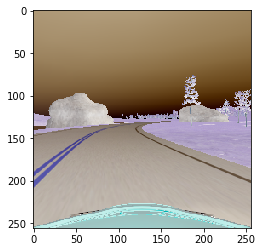

In [2]:
# Load hdf5 file and get the whole training (batch=-1)
#data = HandleData(path='DrivingData_Complete.h5',shuffle = False)
data = HandleData(path=HDF5_PATH,shuffle = False)
xs, ys = data.get_dataset_set()
plt.imshow(xs[0])
plt.show()

In [3]:
# get size in bytes of lists
size_bytes_images = xs[0].nbytes * len(xs)
size_bytes_labels = sys.getsizeof(ys)
total_size = size_bytes_images + size_bytes_labels
print('Total size(bytes): %d' % (size_bytes_images+size_bytes_labels))
print('Number of elements:', len(ys))
print('Type of images: ', type(xs[0]), 'of', xs[0].dtype)
print('Type of labels: ', type(ys[0]), 'of', ys[0].dtype)

# Convert shape tupple into string separated with '_
shape_img = xs[0].shape
shape_str = '_'.join([str(dim) for dim in shape_img])
print('Image shape',xs[0].shape)
print('Image size in bytes',xs[0].nbytes)

Total size(bytes): 739254648
Number of elements: 940
Type of images:  <class 'numpy.ndarray'> of float32
Type of labels:  <class 'numpy.float32'> of float32
Image shape (256, 256, 3)
Image size in bytes 786432


In [4]:
# Open LMDB file
# You can append more information up to the total size.
env = lmdb.open(LMDB_PATH, map_size=total_size*3)

In [5]:
# Get a write lmdb transaction, lmdb store stuff with a key,value(in bytes) format
with env.begin(write=True) as txn:
    # Iterate on batch
    idx = 0
    for (tup_element) in list(zip(xs, ys)):
        img,steer = tup_element        
        str_id = 'label_{:08}'.format(idx)   
        # Encode shape information on key
        img_id = ('img_{:08}_' + shape_str).format(idx)           
        # The current type of steer is np.float32 and img ndarray of float32
        txn.put(bytes(str_id.encode('ascii')),steer.tobytes())                
        txn.put(bytes(img_id.encode('ascii')),img.tobytes())                
        #print('Label size:', len(steer.tobytes()))
        #print('Image size:', len(img.tobytes()))
        idx += 1

### Reading from lmdb

In [6]:
lst_labels = []
lst_imgs = []
env = lmdb.open(LMDB_PATH, readonly=True)
with env.begin() as txn:
    cursor = txn.cursor()
    for key, value in cursor:        
        #print(key, np.frombuffer(value, dtype=np.float32))
        #print(key, value)
        key_str = key.decode('ascii')
        #print(key_str)
        if 'label' in key_str:
            #print('Label size:', len(value))            
            lst_labels.append(np.float32(np.asscalar(np.frombuffer(value, dtype=np.float32, count=1))))
        else:
            # Must be images            
            #print('Image size:', len(value))
            # Get shape information from key name
            info_key = key_str.split('_')
            # Get image shape [2:None] means from index 2 to the end
            shape_img = tuple(map(lambda x:int(x) ,info_key[2:None]))            
            lst_imgs.append(np.frombuffer(value, dtype=np.float32).reshape(shape_img))            

Number of labels on lmdb: 940 are equal: True
Number of images on lmdb: 940 are equal: True


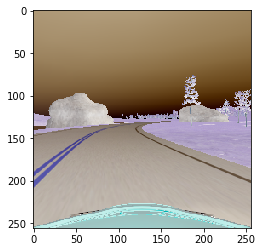

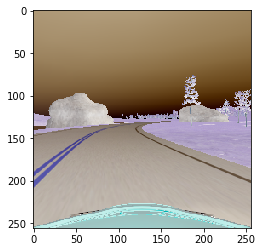

In [7]:
print('Number of labels on lmdb:',len(lst_labels), 'are equal:', lst_labels == ys)
print('Number of images on lmdb:',len(lst_imgs), 'are equal:', np.array_equal(xs,lst_imgs))
plt.imshow(xs[0])
plt.show()
plt.imshow(lst_imgs[0])
plt.show()

### Using with class HandleData

Loading training data
LMDB file
Spliting training and validation
Number training images: 3760
Number validation images: 940


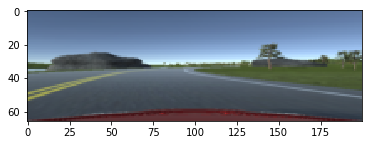

In [12]:
data = HandleData('TestData',shuffle = False)
xs,ys = data.LoadTrainBatch(10, crop_up=0)
plt.imshow(xs[0])
plt.show()